# Autocorrelations

## Imports

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

%autoreload 2
%matplotlib notebook

from l2hmc_eager import gauge_dynamics_eager as gde

Using TensorFlow backend.


In [3]:
from lattice.gauge_lattice import GaugeLattice

In [4]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

from u1_model_eager import GaugeModelEager, train_one_iter
from gauge_model import GaugeModel

import utils.gauge_model_helpers as helpers

## Helper functions

In [5]:
def plot_multiple_lines(x_data, y_data, x_label, y_label, 
                        semilogy=False, legend=True, out_file=None):
    fig, ax = plt.subplots()
    plot_fn = ax.plot
    if semilogy:
        plot_fn = ax.semilogy
    for idx, row in enumerate(y_data):
        _ = plot_fn(x_data, row, ls='-', marker='', 
                    alpha=0.7, lw=1.5, label=f'sample {idx}')

    _ = plot_fn(x_data, y_data.mean(axis=0), marker='', ls='-', 
                color='k', lw=2., label='average')
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    if legend:
        ax.legend(loc='best')
    if out_file:
        print(f'Saving figure to {out_file}.')
        fig.savefig(out_file, dpi=400, bbox_inches='tight')
    return fig, ax

In [6]:
def autocovariance(X, tau=0):
  dT, dN, dX = np.shape(X)
  s = 0.
  for t in range(dT - tau):
    x1 = X[t, :, :]
    x2 = X[t+tau, :, :]

    s += np.sum(x1 * x2) / dN

  return s / (dT - tau)

def acl_spectrum(X, scale):
    n = X.shape[0]
    return np.array([autocovariance(X / scale, tau=t) for t in range(n-1)])

In [7]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result /= result[result.argmax()]
    return result[result.size//2:]

In [8]:
def plot_broken_xaxis(xdata, ydata, xlabel, ylabel, output_file=None,
                      xlim1=(-2, 100), xlim2=(398,  500)):
    fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
    # plot the same data on both axes
    for idx in range(ydata.shape[1]):
        _ = ax.plot(xdata, ydata[:, idx], marker='', ls='-', 
                    alpha=0.7, lw=1.5, label=f'sample {idx}')

    _ = ax.plot(xdata, ydata.mean(axis=1), marker='', ls='-', 
                color='k', lw=2., label='average')

    for idx in range(ydata.shape[1]):
        _ = ax2.plot(xdata, ydata[:, idx], marker='', ls='-', 
                     alpha=0.7, lw=1.5, label=f'sample {idx}')

    _ = ax2.plot(xdata, ydata.mean(axis=1), marker='', ls='-', 
                 color='k', lw=2., label='average')

    # zoom-in / limit the view to different portions of the data
    _ = ax.set_xlim(xlim1)
    _ = ax2.set_xlim(xlim2)

    # hide the spines between ax and ax2
    _ = ax.spines['right'].set_visible(False)
    _ = ax2.spines['left'].set_visible(False)
    _ = ax.yaxis.tick_left()
    _ = ax.tick_params(labelright=False)
    _ = ax2.yaxis.tick_right()

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    _ = ax.plot((1-d,1+d), (-d,+d), **kwargs)
    _ = ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

    _ = kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    _ = ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    _ = ax2.plot((-d,+d), (-d,+d), **kwargs)

    _ = ax.set_ylabel(ylabel, fontsize=14)
    label = ax.set_xlabel(xlabel, fontsize=14)
    _ = ax.xaxis.set_label_coords(1.1, -0.065)
    _ = ax2.legend(loc='best', fontsize=10)

    _ = plt.show()
    if output_file is not None:
        fig.savefig(output_file, dpi=400, bbox_inches='tight')
    return fig, ax, ax2

## Specify run directory containing parameters and samples 

In [61]:
log_dir = '../../gauge_logs_graph/run_68/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [62]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [63]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [64]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

step: 0  time / step: 0.05451  avg action: 365.1   avg plaquette: 0.4295 top charge: -0.02777
step: 1  time / step: 0.04997  avg action: 250.2   avg plaquette: 0.609  top charge: -0.01962
step: 2  time / step: 0.04856  avg action: 202.3   avg plaquette: 0.6839 top charge: 0.09508
step: 3  time / step: 0.05085  avg action: 179.8   avg plaquette: 0.719  top charge: -0.007853
step: 4  time / step: 0.0543  avg action: 158.3   avg plaquette: 0.7527 top charge: 0.003266
step: 5  time / step: 0.04612  avg action: 142.3   avg plaquette: 0.7776 top charge: -0.02287
step: 6  time / step: 0.04656  avg action: 128.4   avg plaquette: 0.7993 top charge: -0.06628
step: 7  time / step: 0.04753  avg action: 117.4   avg plaquette: 0.8166 top charge: 0.02529
step: 8  time / step: 0.04468  avg action: 114.5   avg plaquette: 0.8211 top charge: -0.006549
step: 9  time / step: 0.04611  avg action: 103.4   avg plaquette: 0.8384 top charge: -0.05051
step: 10  time / step: 0.04374  avg action: 102.8   avg plaqu

step: 90  time / step: 0.04802  avg action: 50.68   avg plaquette: 0.9208 top charge: -0.00712
step: 91  time / step: 0.04313  avg action: 50.16   avg plaquette: 0.9216 top charge: -0.006087
step: 92  time / step: 0.04382  avg action: 55.76   avg plaquette: 0.9129 top charge: 0.01826
step: 93  time / step: 0.04704  avg action: 55.85   avg plaquette: 0.9127 top charge: 0.01238
step: 94  time / step: 0.04637  avg action: 53.27   avg plaquette: 0.9168 top charge: -0.02627
step: 95  time / step: 0.04552  avg action: 53.46   avg plaquette: 0.9165 top charge: 0.006511
step: 96  time / step: 0.04624  avg action: 51.65   avg plaquette: 0.9193 top charge: 0.03252
step: 97  time / step: 0.04851  avg action:  52.1   avg plaquette: 0.9186 top charge: -0.05515
step: 98  time / step: 0.05159  avg action: 53.36   avg plaquette: 0.9166 top charge: 0.002913
step: 99  time / step: 0.06645  avg action:   55    avg plaquette: 0.9141 top charge: -0.005059
step: 100  time / step: 0.2461  avg action: 55.68  

step: 176  time / step: 0.1858  avg action: 56.41   avg plaquette: 0.9119 top charge: 0.04403
step: 177  time / step: 0.07585  avg action: 51.75   avg plaquette: 0.9191 top charge: -0.0281
step: 178  time / step: 0.1565  avg action: 52.69   avg plaquette: 0.9177 top charge: -0.005714
step: 179  time / step: 0.119   avg action: 47.81   avg plaquette: 0.9253 top charge: -0.01129
step: 180  time / step: 0.04673  avg action: 51.81   avg plaquette: 0.919  top charge: -0.004098
step: 181  time / step: 0.1021  avg action: 50.47   avg plaquette: 0.9211 top charge: 0.00136
step: 182  time / step: 0.1344  avg action: 52.66   avg plaquette: 0.9177 top charge: -0.0001349
step: 183  time / step: 0.089   avg action: 53.73   avg plaquette: 0.916  top charge: -0.002935
step: 184  time / step: 0.1968  avg action: 54.78   avg plaquette: 0.9144 top charge: -0.00306
step: 185  time / step: 0.1297  avg action: 54.28   avg plaquette: 0.9152 top charge: 0.004932
step: 186  time / step: 0.06439  avg action: 5

step: 262  time / step: 0.0431  avg action:  42.7   avg plaquette: 0.9333 top charge: -0.05259
step: 263  time / step: 0.04165  avg action: 45.32   avg plaquette: 0.9292 top charge: 0.01485
step: 264  time / step: 0.04092  avg action: 45.16   avg plaquette: 0.9294 top charge: -0.05223
step: 265  time / step: 0.04228  avg action: 42.54   avg plaquette: 0.9335 top charge: 0.01432
step: 266  time / step: 0.04268  avg action:  43.1   avg plaquette: 0.9327 top charge: 0.01218
step: 267  time / step: 0.04287  avg action: 44.68   avg plaquette: 0.9302 top charge: -0.04115
step: 268  time / step: 0.04163  avg action: 44.82   avg plaquette:  0.93  top charge: -0.00353
step: 269  time / step: 0.04137  avg action: 43.53   avg plaquette: 0.932  top charge: -0.0285
step: 270  time / step: 0.04181  avg action: 42.64   avg plaquette: 0.9334 top charge: 0.005794
step: 271  time / step: 0.04218  avg action:  41.7   avg plaquette: 0.9349 top charge: -0.0153
step: 272  time / step: 0.04278  avg action:  

step: 351  time / step: 0.04329  avg action: 44.32   avg plaquette: 0.9308 top charge: -0.01543
step: 352  time / step: 0.04221  avg action: 44.73   avg plaquette: 0.9301 top charge: 0.007205
step: 353  time / step: 0.04134  avg action: 44.04   avg plaquette: 0.9312 top charge: -0.004434
step: 354  time / step: 0.04125  avg action: 39.85   avg plaquette: 0.9377 top charge: -0.002199
step: 355  time / step: 0.04156  avg action: 44.34   avg plaquette: 0.9307 top charge: -0.01023
step: 356  time / step: 0.04422  avg action: 44.01   avg plaquette: 0.9312 top charge: 0.0114
step: 357  time / step: 0.04456  avg action: 40.68   avg plaquette: 0.9364 top charge: -0.004349
step: 358  time / step: 0.04554  avg action: 43.78   avg plaquette: 0.9316 top charge: 0.01568
step: 359  time / step: 0.05281  avg action: 47.32   avg plaquette: 0.9261 top charge: 0.02715
step: 360  time / step: 0.05374  avg action: 47.68   avg plaquette: 0.9255 top charge: 0.005861
step: 361  time / step: 0.05761  avg acti

step: 437  time / step: 0.05159  avg action: 42.36   avg plaquette: 0.9338 top charge: -0.03134
step: 438  time / step: 0.04776  avg action: 45.14   avg plaquette: 0.9295 top charge: 0.02316
step: 439  time / step: 0.04708  avg action:  41.3   avg plaquette: 0.9355 top charge: -0.03401
step: 440  time / step: 0.04771  avg action: 41.04   avg plaquette: 0.9359 top charge: 0.0418
step: 441  time / step: 0.04811  avg action: 40.48   avg plaquette: 0.9368 top charge: -0.02669
step: 442  time / step: 0.04812  avg action: 40.05   avg plaquette: 0.9374 top charge: -0.002093
step: 443  time / step: 0.04675  avg action: 47.54   avg plaquette: 0.9257 top charge: 0.03128
step: 444  time / step: 0.04618  avg action: 46.31   avg plaquette: 0.9276 top charge: -0.0613
step: 445  time / step: 0.04308  avg action: 46.12   avg plaquette: 0.9279 top charge: -0.005413
step: 446  time / step: 0.04415  avg action: 42.76   avg plaquette: 0.9332 top charge: 0.02216
step: 447  time / step: 0.0448  avg action: 

step: 523  time / step: 0.1345  avg action: 40.67   avg plaquette: 0.9365 top charge: -0.01722
step: 524  time / step: 0.1162  avg action: 43.01   avg plaquette: 0.9328 top charge: 0.008102
step: 525  time / step: 0.07034  avg action: 39.95   avg plaquette: 0.9376 top charge: -0.0338
step: 526  time / step: 0.1339  avg action: 37.59   avg plaquette: 0.9413 top charge: 0.03761
step: 527  time / step: 0.08235  avg action: 40.01   avg plaquette: 0.9375 top charge: -0.004992
step: 528  time / step: 0.06182  avg action: 45.68   avg plaquette: 0.9286 top charge: 0.02542
step: 529  time / step: 0.06491  avg action: 40.91   avg plaquette: 0.9361 top charge: -0.004997
step: 530  time / step: 0.06099  avg action: 40.89   avg plaquette: 0.9361 top charge: -0.01053
step: 531  time / step: 0.07369  avg action:  38.8   avg plaquette: 0.9394 top charge: 0.01178
step: 532  time / step: 0.08967  avg action:  45.5   avg plaquette: 0.9289 top charge: -0.005678
step: 533  time / step: 0.1068  avg action: 

step: 612  time / step: 0.04874  avg action:   40    avg plaquette: 0.9375 top charge: 0.07038
step: 613  time / step: 0.04726  avg action: 43.85   avg plaquette: 0.9315 top charge: 0.02107
step: 614  time / step: 0.04381  avg action: 35.94   avg plaquette: 0.9438 top charge: 0.005471
step: 615  time / step: 0.04153  avg action: 36.98   avg plaquette: 0.9422 top charge: 0.006199
step: 616  time / step: 0.04411  avg action: 37.95   avg plaquette: 0.9407 top charge: 0.02484
step: 617  time / step: 0.04449  avg action: 36.91   avg plaquette: 0.9423 top charge: -0.05875
step: 618  time / step: 0.04253  avg action: 40.46   avg plaquette: 0.9368 top charge: -0.03038
step: 619  time / step: 0.0428  avg action: 45.54   avg plaquette: 0.9288 top charge: -0.02457
step: 620  time / step: 0.04554  avg action: 41.99   avg plaquette: 0.9344 top charge: -0.01123
step: 621  time / step: 0.04422  avg action: 39.15   avg plaquette: 0.9388 top charge: -0.02403
step: 622  time / step: 0.04446  avg action:

step: 700  time / step: 0.06051  avg action: 43.95   avg plaquette: 0.9313 top charge: 0.0004501
step: 701  time / step: 0.05658  avg action: 42.69   avg plaquette: 0.9333 top charge: -0.01488
step: 702  time / step: 0.073   avg action: 41.58   avg plaquette: 0.935  top charge: 0.006243
step: 703  time / step: 0.04787  avg action: 35.86   avg plaquette: 0.944  top charge: -0.0574
step: 704  time / step: 0.054   avg action: 38.49   avg plaquette: 0.9399 top charge: -0.04056
step: 705  time / step: 0.0463  avg action: 42.99   avg plaquette: 0.9328 top charge: -0.0415
step: 706  time / step: 0.08087  avg action: 44.33   avg plaquette: 0.9307 top charge: -0.05111
step: 707  time / step: 0.04689  avg action: 42.95   avg plaquette: 0.9329 top charge: -0.02994
step: 708  time / step: 0.04962  avg action: 39.71   avg plaquette: 0.9379 top charge: -0.03188
step: 709  time / step: 0.05632  avg action:  41.3   avg plaquette: 0.9355 top charge: -0.01054
step: 710  time / step: 0.05195  avg action:

step: 786  time / step: 0.065   avg action: 37.45   avg plaquette: 0.9415 top charge: 0.006968
step: 787  time / step: 0.04934  avg action:  41.2   avg plaquette: 0.9356 top charge: -0.04025
step: 788  time / step: 0.04938  avg action: 42.97   avg plaquette: 0.9329 top charge: 0.003956
step: 789  time / step: 0.04823  avg action: 40.51   avg plaquette: 0.9367 top charge: -0.03481
step: 790  time / step: 0.04538  avg action:  40.9   avg plaquette: 0.9361 top charge: -0.03283
step: 791  time / step: 0.04425  avg action: 36.14   avg plaquette: 0.9435 top charge: -0.00372
step: 792  time / step: 0.04348  avg action:  37.4   avg plaquette: 0.9416 top charge: -0.004509
step: 793  time / step: 0.04472  avg action:  41.1   avg plaquette: 0.9358 top charge: 0.01652
step: 794  time / step: 0.04553  avg action: 41.33   avg plaquette: 0.9354 top charge: 0.06586
step: 795  time / step: 0.0444  avg action:  39.1   avg plaquette: 0.9389 top charge: 0.02976
step: 796  time / step: 0.0437  avg action: 

step: 874  time / step: 0.04706  avg action: 32.91   avg plaquette: 0.9486 top charge: -0.0008099
step: 875  time / step: 0.04729  avg action: 34.05   avg plaquette: 0.9468 top charge: -0.02814
step: 876  time / step: 0.04753  avg action: 37.24   avg plaquette: 0.9418 top charge: -0.001274
step: 877  time / step: 0.04524  avg action: 41.95   avg plaquette: 0.9345 top charge: -0.02808
step: 878  time / step: 0.04211  avg action: 40.04   avg plaquette: 0.9374 top charge: 0.006388
step: 879  time / step: 0.04396  avg action:  36.3   avg plaquette: 0.9433 top charge: -0.003176
step: 880  time / step: 0.04262  avg action: 37.57   avg plaquette: 0.9413 top charge: 0.01167
step: 881  time / step: 0.04138  avg action: 35.54   avg plaquette: 0.9445 top charge: -0.02548
step: 882  time / step: 0.04427  avg action:  36.3   avg plaquette: 0.9433 top charge: -0.004314
step: 883  time / step: 0.04353  avg action: 36.04   avg plaquette: 0.9437 top charge: -0.002463
step: 884  time / step: 0.04848  av

step: 961  time / step: 0.07655  avg action: 39.73   avg plaquette: 0.9379 top charge: -0.05112
step: 962  time / step: 0.06312  avg action: 41.57   avg plaquette: 0.935  top charge: -0.003738
step: 963  time / step: 0.04391  avg action: 38.89   avg plaquette: 0.9392 top charge: -0.007176
step: 964  time / step: 0.04415  avg action: 33.59   avg plaquette: 0.9475 top charge: -0.01178
step: 965  time / step: 0.04323  avg action:  37.6   avg plaquette: 0.9412 top charge: -0.03775
step: 966  time / step: 0.04485  avg action: 37.44   avg plaquette: 0.9415 top charge: -0.02051
step: 967  time / step: 0.04305  avg action:  39.3   avg plaquette: 0.9386 top charge: -0.03759
step: 968  time / step: 0.0439  avg action: 37.62   avg plaquette: 0.9412 top charge: 0.01838
step: 969  time / step: 0.04487  avg action: 39.79   avg plaquette: 0.9378 top charge: -0.03809
step: 970  time / step: 0.04412  avg action:  41.9   avg plaquette: 0.9345 top charge: -0.0176
step: 971  time / step: 0.04475  avg acti

In [65]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [66]:
len(samples_history[0].shape)

4

In [67]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [68]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

<IPython.core.display.Javascript object>


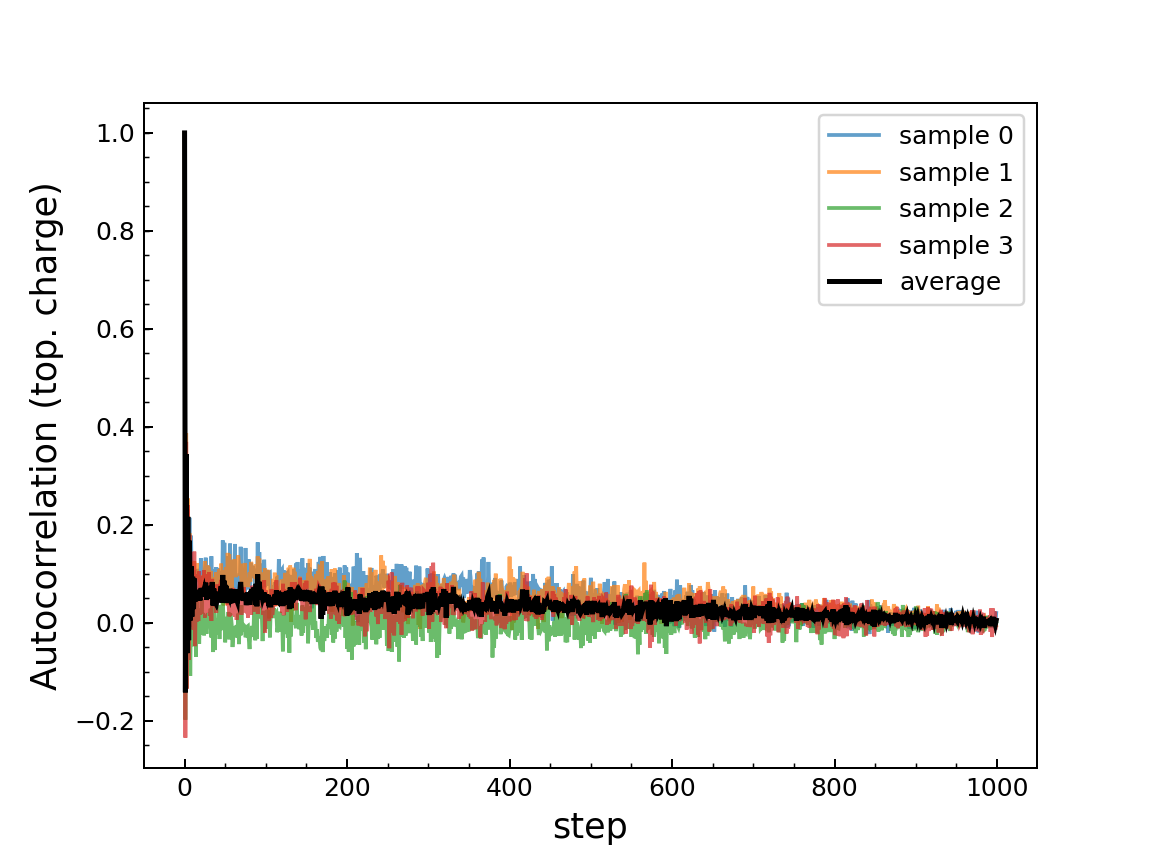

Saving figure to ../../gauge_logs_graph/run_68/figures/topological_charge_autocorr_fn.pdf.


In [69]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

<IPython.core.display.Javascript object>


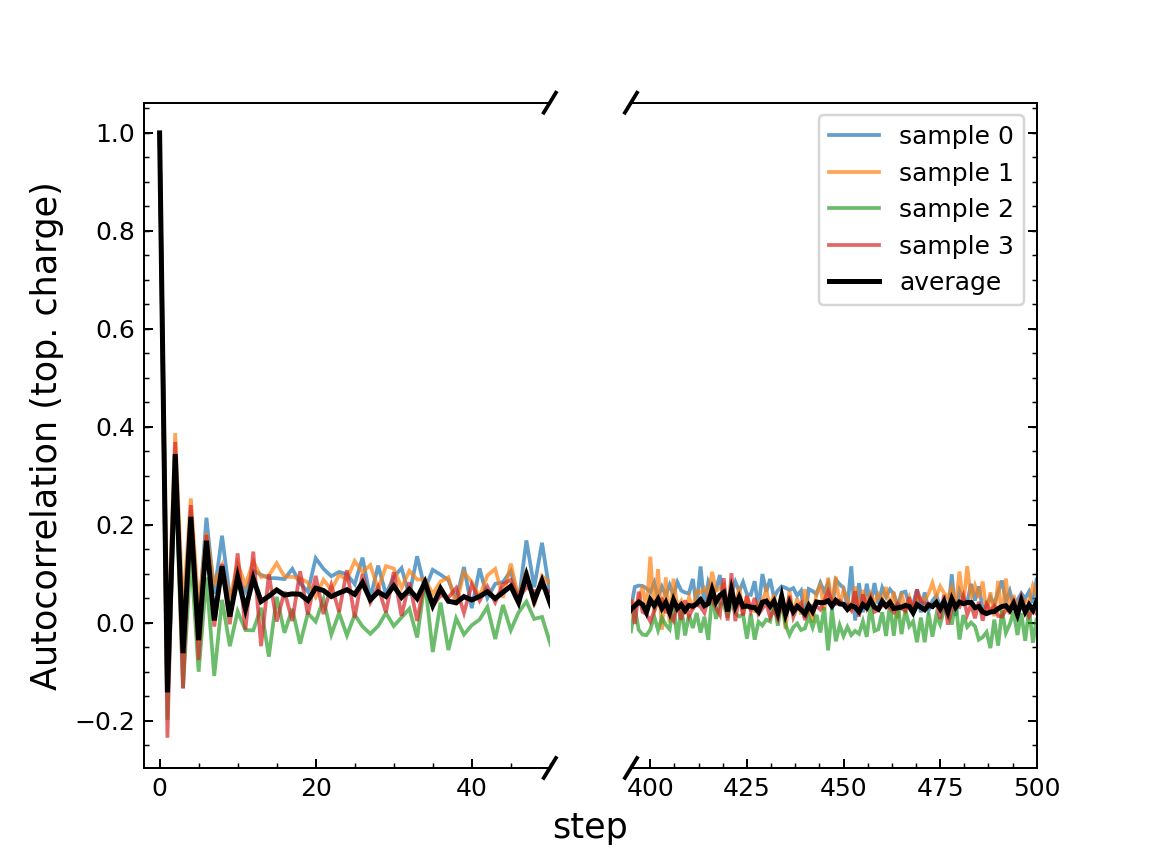

In [70]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

<IPython.core.display.Javascript object>


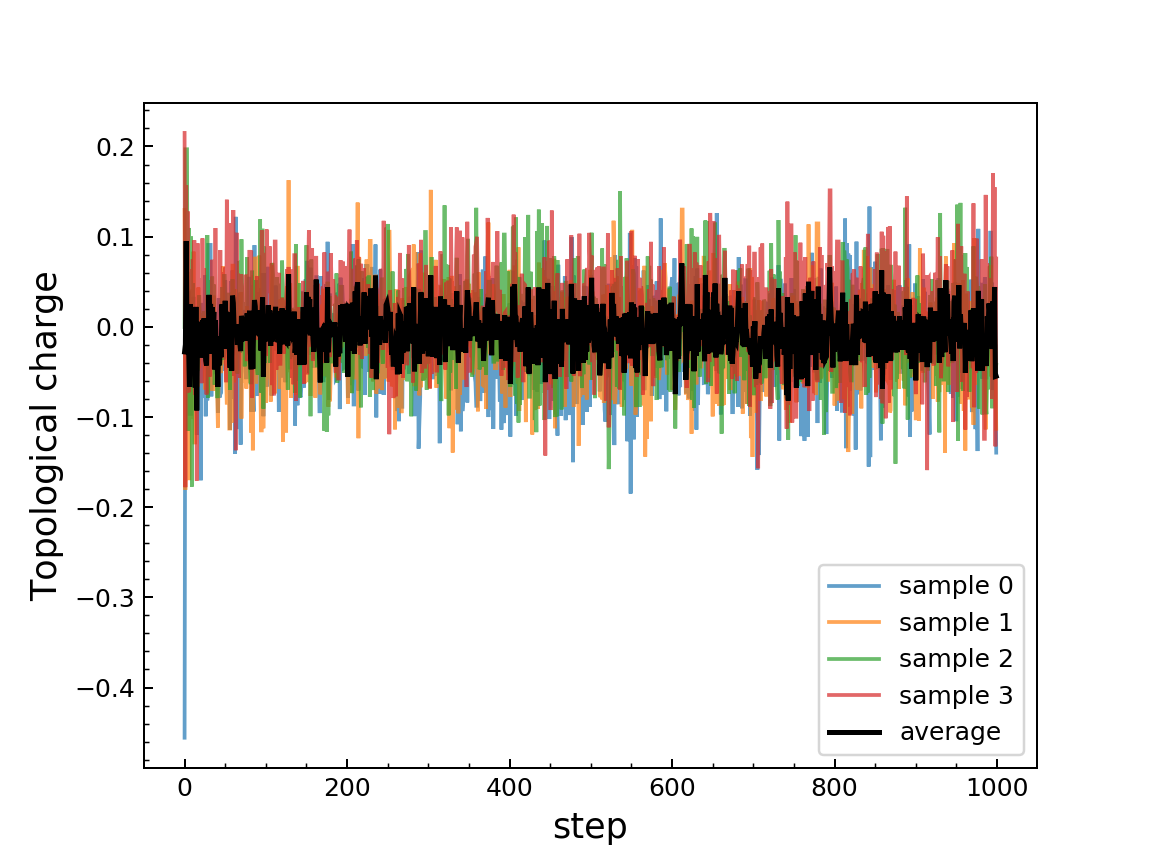

Saving figure to ../../gauge_logs_graph/run_68/figures/topological_charge_vs_step.pdf.


In [71]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge',
                              out_file=out_file)

<IPython.core.display.Javascript object>


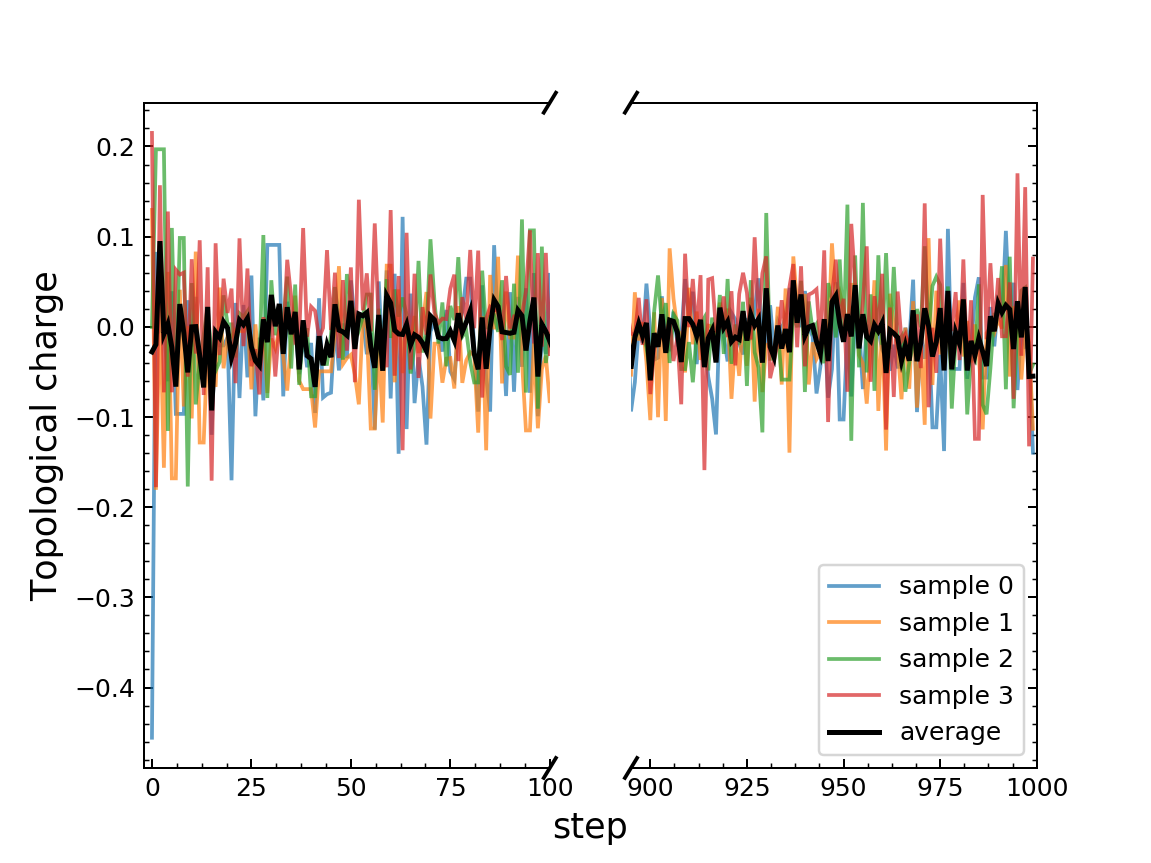

In [72]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(895, 1000),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [73]:
from lattice.gauge_lattice import u1_plaq_exact

<IPython.core.display.Javascript object>


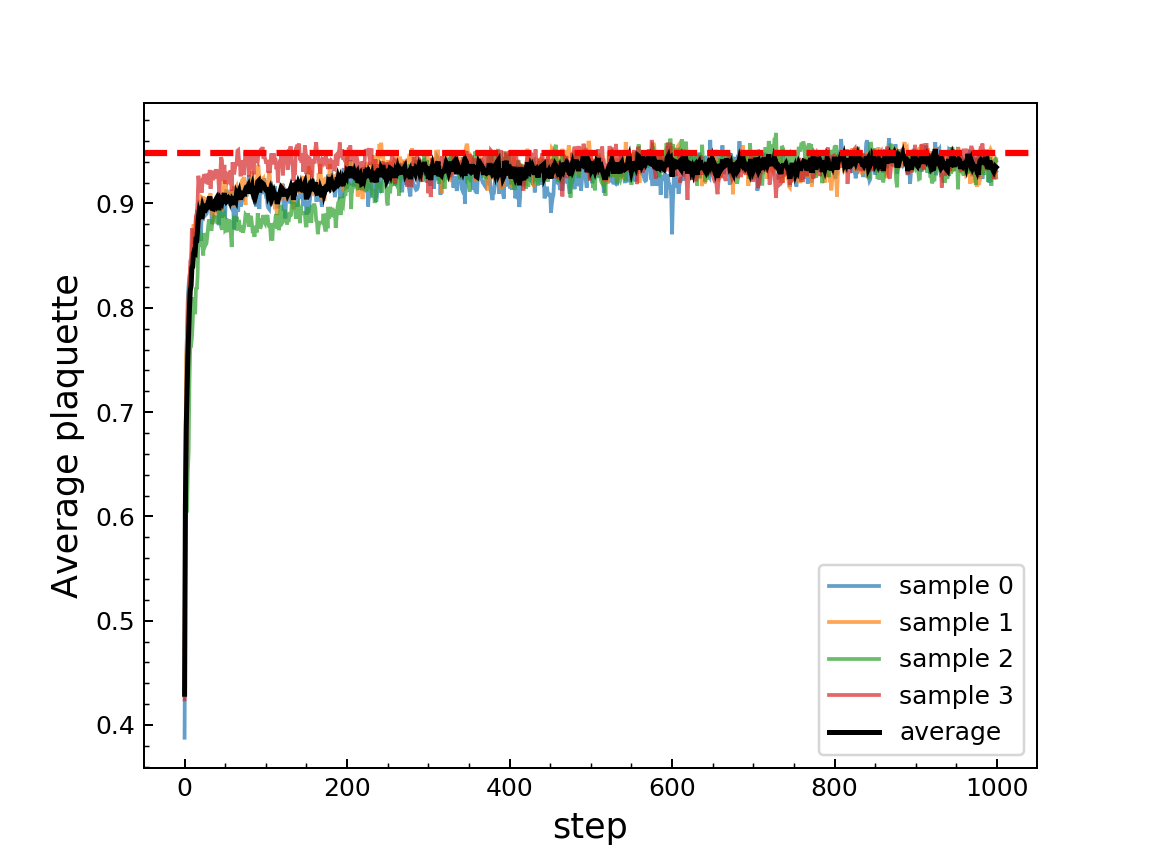

In [74]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

<IPython.core.display.Javascript object>


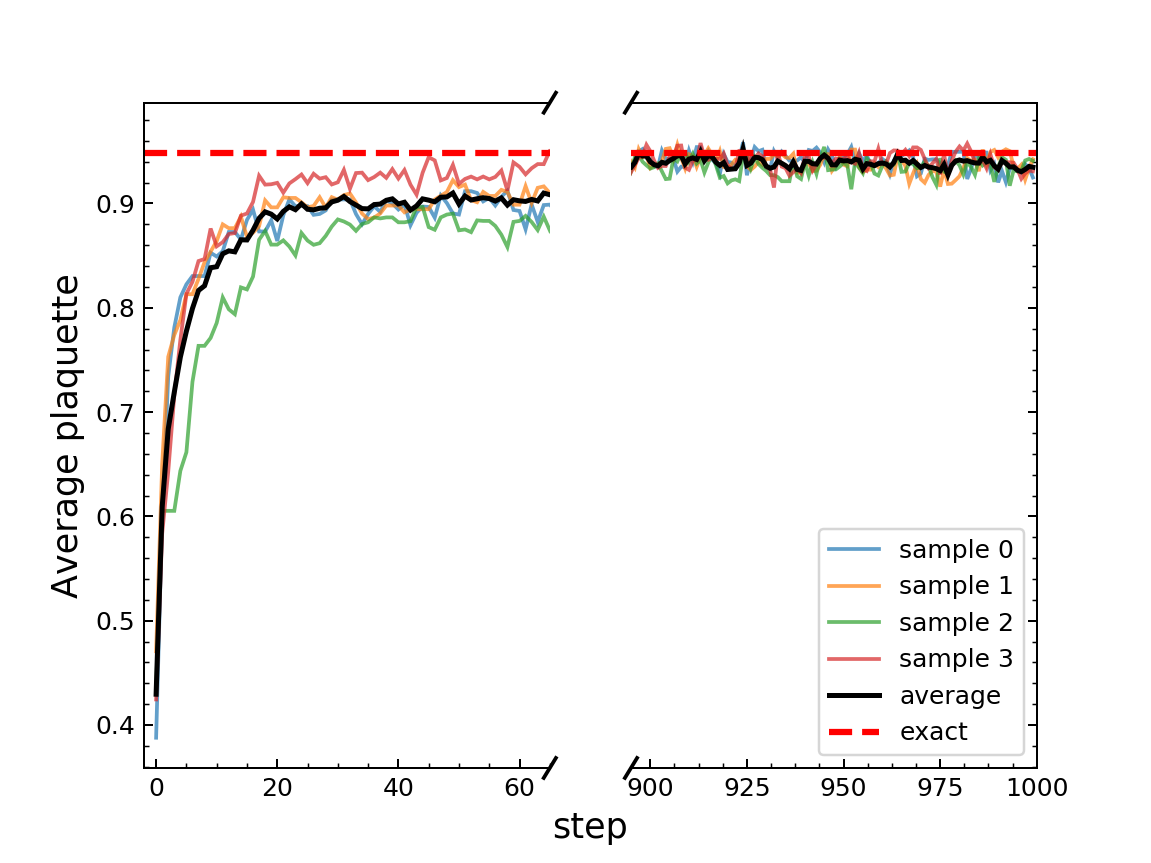

In [75]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(895, 1000),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


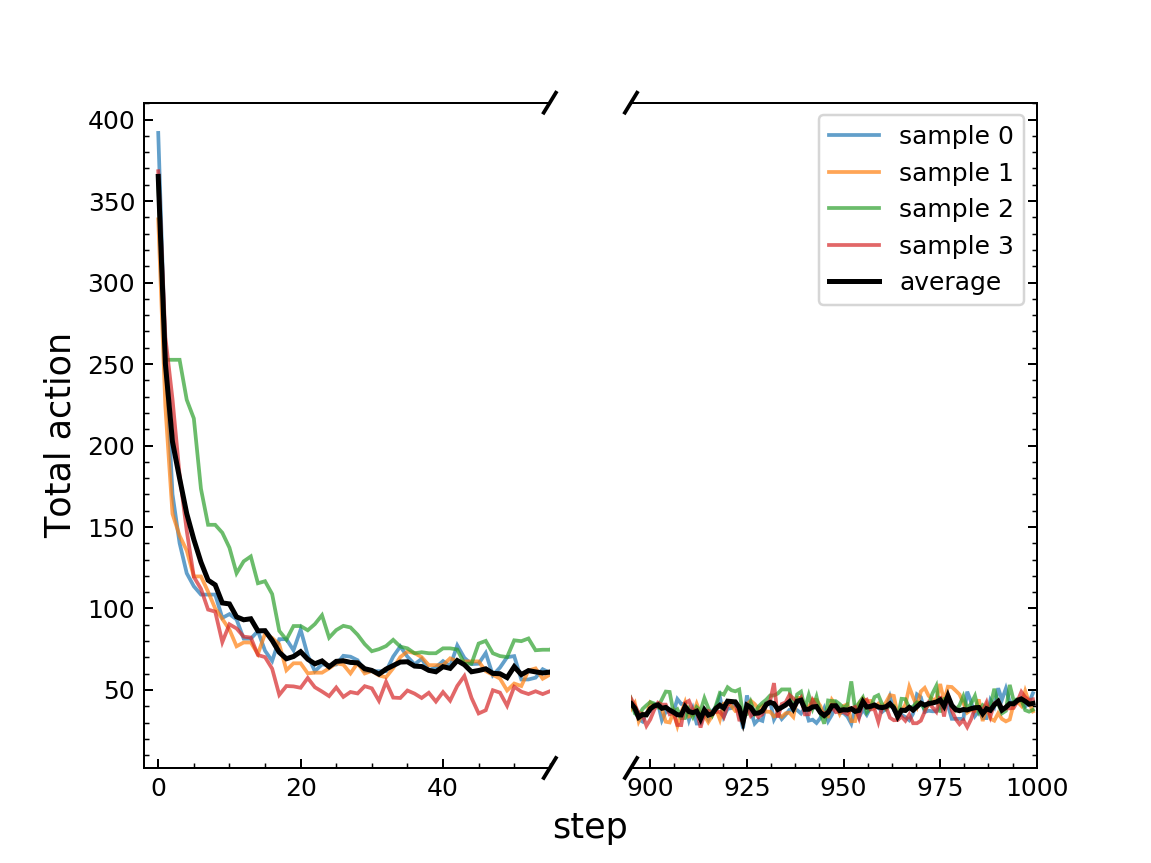

In [76]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(895, 1000),
                                 output_file=out_file)

In [77]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

<IPython.core.display.Javascript object>


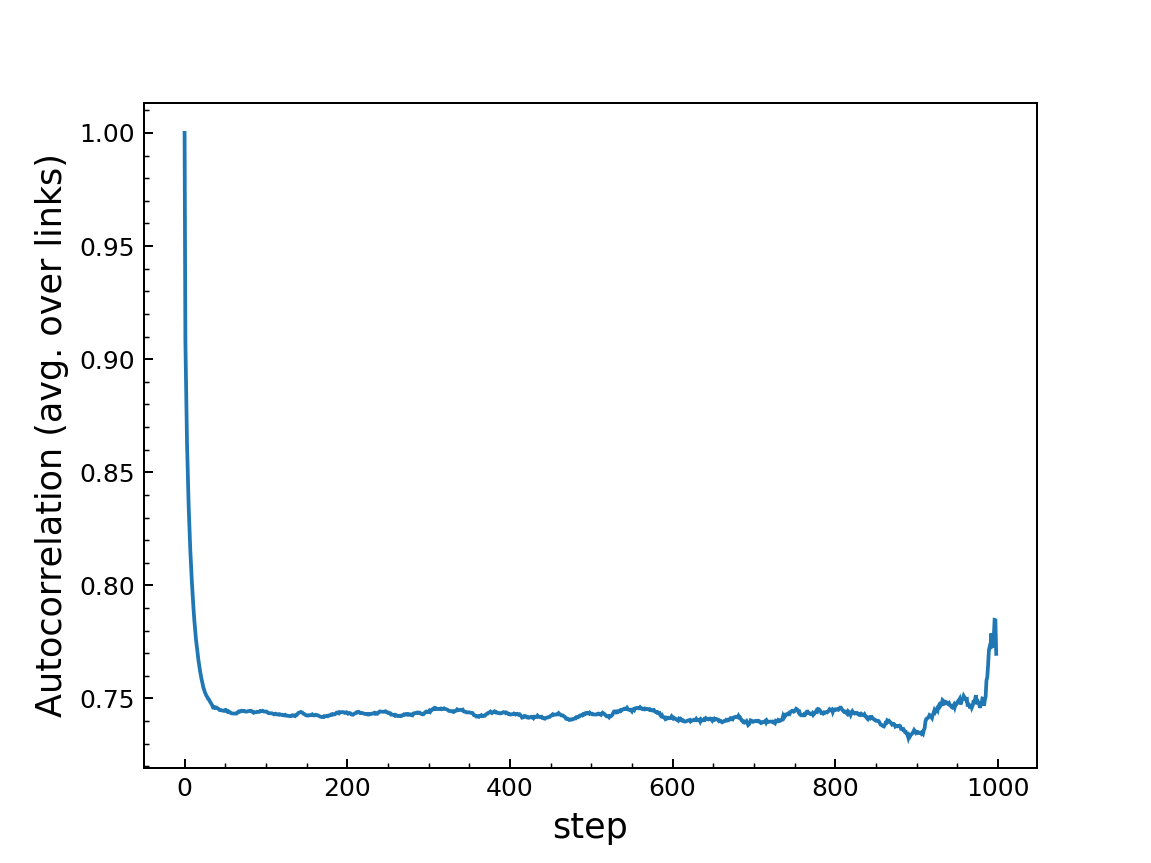

Text(0.5,0,'step')

Text(0,0.5,'Autocorrelation (avg. over links)')

In [78]:
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

## Compare Sample Autocorrelation across runs

In [132]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [137]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [143]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [152]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

(500,)

<IPython.core.display.Javascript object>


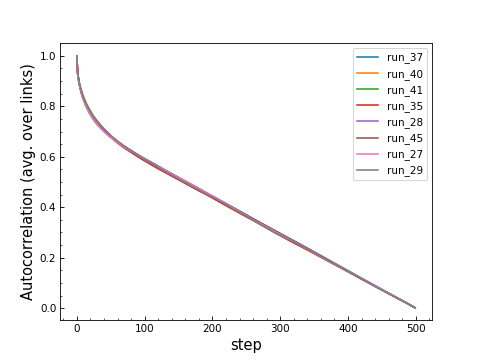

In [162]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [1]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

### Incorrect

<IPython.core.display.Javascript object>


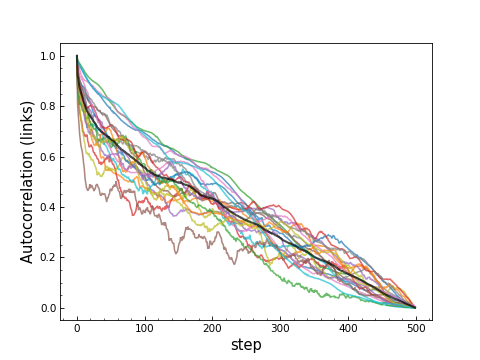

Saving figure to ../../gauge_logs_graph/run_40/figures/samples_acl_spectrum.pdf.


In [19]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

<IPython.core.display.Javascript object>


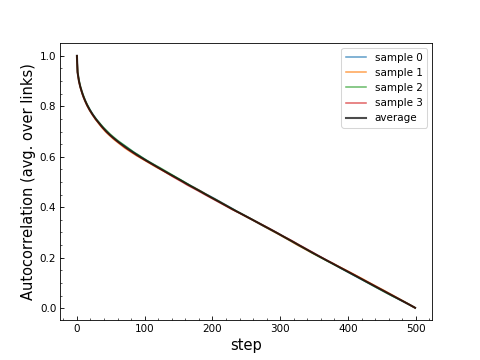

Saving figure to ../../gauge_logs_graph/run_40/figures/samples_acl_spectrum_avg.pdf.


In [20]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [92]:
tf.InteractiveSession.close

<function tensorflow.python.client.session.InteractiveSession.close(self)>

In [105]:
tf.Session().close()

In [90]:
#sess = tf.InteractiveSession()

/Users/saforem2/Library/Python/3.6/lib/python/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [106]:
tf.reset_default_graph()

In [107]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [108]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [109]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [110]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [111]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [112]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [113]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

ValueError: Fetch argument <tf.Operation 'make_initializer' type=MakeIterator> cannot be interpreted as a Tensor. (Operation name: "make_initializer"
op: "MakeIterator"
input: "MapDataset"
input: "IteratorV2"
device: "/device:CPU:0"
attr {
  key: "_class"
  value {
    list {
      s: "loc:@IteratorV2"
    }
  }
}
 is not an element of this graph.)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [99]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [100]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [102]:
dataset.output_shapes

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(2)])

In [104]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [103]:
dataset.apply(dynamics.apply_transition)

TypeError: Failed to convert object of type <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> to Tensor. Contents: <BatchDataset shapes: (?, 8, 8, 2), types: tf.float32>. Consider casting elements to a supported type.

In [85]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [76]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [51]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [52]:
dataset

<TensorDataset shapes: (2, 8, 8, 2), types: tf.float32>

In [41]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

TypeError: Failed to convert object of type <class 'tensorflow.python.data.ops.dataset_ops.TensorDataset'> to Tensor. Contents: <TensorDataset shapes: (2, 8, 8, 2), types: tf.float32>. Consider casting elements to a supported type.

In [53]:
iterator = dataset.make_initializable_iterator()

In [54]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.

In [55]:
next_element = iterator.get_next()

In [56]:
result = dynamics.apply_transition(next_element)

In [58]:
sess.run(result)

ValueError: Fetch argument <tf.Tensor 'add_6260:0' shape=(2, 8, 8, 2) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("add_6260:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})